# dfencoder Demo: Census Dataset
This is a demonstration of the dfencoder library. We will use the [adult census dataset](https://archive.ics.uci.edu/ml/datasets/adult) for this demo.

In [0]:
#these are our libraries
from dfencoder import AutoEncoder
import numpy as np
import pandas as pd

#and, for pretty visualiations...
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%config InlineBackend.figure_format = 'retina'

# About the Data
This dataset contains information about 32,561 adults (in the training set), with a number of features.<br><br>
Traditionally, the target variable is "salary," a binary feature with "<50k" and ">=50k" as its two values. For this now, we'll treat this column as we do all the others.

In [3]:
#load and look at the data
df = pd.read_csv('https://github.com/AlliedToasters/dfencoder/raw/master/adult.csv')

#this dataset contains nulls and ' ?'. Let's make these all nulls.
df = df.applymap(lambda x: np.nan if x==' ?' else x)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


# Validation on Hold-Out Set
Even in unsupervised learning, it's a good idea to do a train/validation split during training. This will help you fine-tune your model and avoid overfitting. Let's hold out 20% of the examples.

In [0]:
train = df.sample(frac=.8, random_state=42)
test = df.loc[~df.index.isin(train.index)]

X_train = train
X_val = test

# Building A Model
Applying DAE, you have to make a lot of choices. How many hidden layers does your model have? What activations will you use? Learning rate? Optimizer? What noise level do you want to apply to the inputs during training?<br>
What about feature scaling? Do you want to use uniform scaling or standard scaling? What about [GaussRank scaling](http://fastml.com/preparing-continuous-features-for-neural-networks-with-rankgauss/), the technique used in a kaggle-winning competition?<br>
dfencoder aims to free you from the burden of data munging so you can focus on optimizing these parameters. Here's an example of how to feed these hyperparameters to your model.

In [0]:
model = AutoEncoder(
    encoder_layers = [512, 512, 512], #model architecture
    decoder_layers = [], #decoder optional - you can create bottlenecks if you like
    activation='relu',
    swap_p=0.2, #noise parameter
    lr = 0.01,
    lr_decay=.99,
    batch_size=512,
    logger='ipynb', #special logging for jupyter notebooks
    verbose=False,
    optimizer='sgd',
    scaler='gauss_rank', #gauss rank scaling forces your numeric features into standard normal distributions
    min_cats=3 #Define cutoff for minority categories, default 10
)

# Fitting the Model
Notice your model doesn't know about the data yet. The model itself won't be built until you call .fit(); on the .fit() call, the model will use the column-wise data types of the input dataframe to determine how to treat each column:
 - Numeric (float or int) columns will be scaled and treated as continuous variables.
     - MSE loss is used for loss on these columns during training.
 - Categorical (category, str or 'object') columns will be treated as categorical, with minority classes (frequency < min_cats argument in constructor) being lumped into a special 'N/A' category.
     - Categorical Cross Entropy is used as a loss during training.
     - These features are embedded into category vectors before being fed into the model.
     - [Category embeddings](https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0) enable efficient learning of relationships between unique categories.
 - Binary (bool or 'object' where n_unique < 3) columns will be treated as binary features.
     - Binary Cross Entropy is used as loss.
     
## Advice on Data Preparation.

     
The idea is to save you time on feature engineering. If you want, you can just throw a dataframe into the .fit() method and something will happen.<br><br>However, you need to understand the way this library is dealing with your data and how it decides what to do. Make sure to clean up your data - pay attention to dtypes - before calling .fit(). This is how you can specify how the model treats each column!

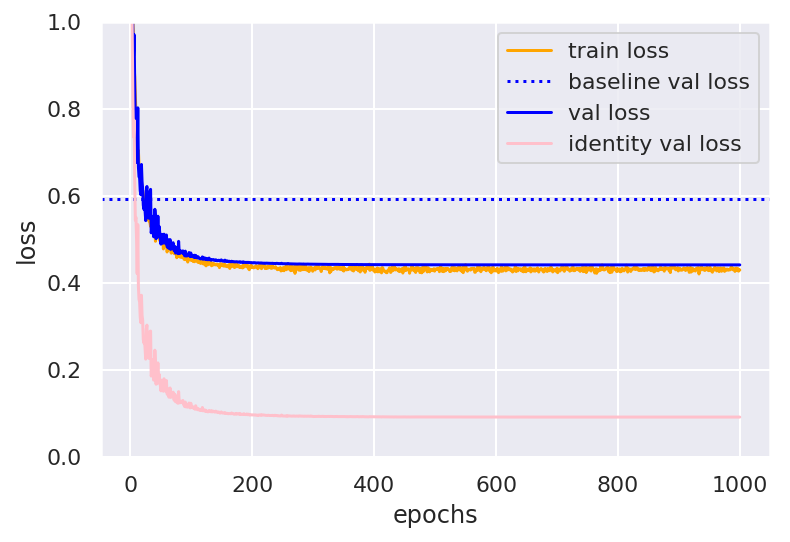

In [6]:
model.fit(X_train, epochs=1000, val=X_val)

# Model Evaluation
How can we tell if the model is performing well? In supervised learning, the answer is straightforward. In self-supervised learning, it may not be so clear at first glance. There are a few terms to consider:
<br>
## Loss
When we talk about loss here, we're talking about the "reconstruction loss." That is, how well does the model predict the *correct* version of the example it's seeing?
## Baseline Validation Loss
If we apply swap noise to our validation set and compute the loss given a strong prediction for the identity function, we can get an idea for what loss to expect from the model when it learns the trivial identity function. You'll see this value printed to your console (or plotted in your notebook if you use the ipynb logger, as in this notebook). Ideally, our model will learn to perform significantly better than this baseline.
## Validation Loss
Keeping the swap noise constant (same input as used in computing baseline), we can see how our model does at the end of each epoch on reconstructing the original, unaltered validation set. This is our standard validation loss. Note: we don't re-apply swap noise on each epoch. We want to keep the validation task constant so each evaluation step is compared "apples-to-apples."
## Identity Loss
The "identity loss" is computed by measuring the reconstruction loss when inputs to the model are unaltered. Although learning the identity function is trivial, a low identity loss in combination with a low validation loss indicates that the model is good at identifying unaltered examples and returning an unchanged output.

# Now What?
The question now is, what can we do with our model? There are a number of applications. Let's look at a few of them.
## "Deep Stack" Features
As in the kaggle-winning solution to the Porto Seguro Safe Driver Prediction competition, we can simply use all the activations concatenated together to extract a bunch of latent features from each example:

In [7]:
z = model.get_deep_stack_features(X_val)
print(z.shape)
print(z[0, :])

torch.Size([6512, 1536])
tensor([1.4443, 0.0000, 0.0000,  ..., 0.0000, 1.1408, 0.9179], device='cuda:0')


In this case, we see that each row now has 1,536 new features associated with it. What can we do with them?
We could start by building a model predict the target feature, "salary".
### BUT WAIT!
Didn't we use salary to train the autoencoder? Won't we be cheating?<br><br>
Well, maybe. In a moment we'll see why that's not exactly important. Let's try to build a model anyway.

In [8]:
X_train.salary.unique()

array(['<50k', '>=50k'], dtype=object)

In [9]:
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import f1_score
import numpy as np
import torch
import tqdm

class ClassifierModel(torch.nn.Module):
    """A simple classifier neural network."""
  
    def __init__(self, *args, **kwargs):
        super(ClassifierModel, self).__init__(*args, **kwargs)
        self.input_dropout = torch.nn.Dropout(.1)
        self.input_layer = torch.nn.Linear(1536, 512)
        self.dropout = torch.nn.Dropout(.5)
        self.dense = torch.nn.Linear(512, 512)
        self.output = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)

        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
    
classifier = ClassifierModel().to("cuda:0")

optim = torch.optim.Adam(
    classifier.parameters(),
    weight_decay=.01
)

decay = torch.optim.lr_scheduler.ExponentialLR(optim, .99)

loss = torch.nn.modules.loss.BCELoss()

def do_step(classifier, optim, z, target, loss):
    pred = classifier(z)
    target = torch.tensor(target).float().reshape(-1, 1).to("cuda:0")
    loss_ = loss(pred, target)
    amnt = loss_.item()
    loss_.backward()
    optim.step()
    optim.zero_grad()
    return amnt

def do_evaluation(classifier, z, target, loss):
    with torch.no_grad():
        pred = classifier(z)
        probs = pred.cpu().numpy().reshape(-1)
        predictions = np.where(probs > .5, 1, 0)

        accuracy = np.where(target==predictions, 1, 0).sum()/len(predictions)
        f1 = f1_score(target, predictions)

        target_ = torch.tensor(target).float().reshape(-1, 1).to("cuda:0")
        loss_ = loss(pred, target_)
        return loss_.item(), accuracy, f1

  
batch_size = 256
n_updates = (len(X_train)//batch_size) + 1

n_epochs = 1000

#To extract features, we'll set the target column on the input
#equal to the majority class: <50k

X_train2 = X_train.copy()
X_train2['salary'] = ['<50k' for _ in X_train2['salary']]
z_train = model.get_deep_stack_features(X_train2)

Y_train = np.where(X_train['salary'].values == '<50k', 0, 1)

X_test2 = X_val.copy()
X_test2['salary'] = ['<50k' for _ in X_test2['salary']]
z_test = model.get_deep_stack_features(X_test2)
Y_test = np.where(X_val['salary'].values == '<50k', 0, 1)

for j in range(n_epochs):
    if j % 100 == 0:
      print(f'{j} epochs complete...')
    for i in range(n_updates):
        step = i
        start = int((step) * batch_size)
        stop = int((step+1) * batch_size)
        in_ = z_train[start:stop]
        target = Y_train[start:stop]
        do_step(classifier, optim, in_, target, loss)
    decay.step()
    bce_loss, accuracy, f1 = do_evaluation(classifier, z_test, Y_test, loss)
print('\nFinal results: ')
print('validation loss: ', round(bce_loss, 4))
print('validation accuracy: ', round(accuracy, 3))
print('validation f1 score: ', round(f1, 3))

0 epochs complete...
100 epochs complete...
200 epochs complete...
300 epochs complete...
400 epochs complete...
500 epochs complete...
600 epochs complete...
700 epochs complete...
800 epochs complete...
900 epochs complete...

Final results: 
validation loss:  0.3266
validation accuracy:  0.85
validation f1 score:  0.647


# How We Handled the Target
If you look at the above code, you'll see what we did to handle the target variable. We just set it to the majority class before inputting into the model - this gives us a test-agnostic way to encode our inputs for the classifier.<br><br>
Of course, the best way to deal with this is to omit the target from your autoencoder training in the first place, but this serves as an example of how we can get around the issue if we want to predict a variable that our autoencoder is expecting.

# Anomaly Detection
Another great application of DAE is anomaly detection. Here's an intuition on how this works:<br><br>
If we input a regular example, unaltered, into the DAE, we expect it to output a strong prediction for the input values. However, if the model sees an "unusual" example, it's going to be less certain. It may even return a strong prediction for different values than the input.<br><br>
We can measure this uncertainty as the loss against the input example against the model output. This value can be interpreted as an anomaly score.<br><br>
dfencoder AutoEncoders have a method to get this for you: .get_anomaly_score()

In [10]:
scores = model.get_anomaly_score(X_val)
X_val['anomaly_score'] = scores
X_val.sort_values('anomaly_score', ascending=False).head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,anomaly_score
21004,32,Private,112137,Preschool,1.0,Married-civ-spouse,Machine-op-inspct,Wife,Asian-Pac-Islander,Female,4508,0,40,Cambodia,<50k,27.913197
10053,17,Private,56536,11th,7.0,Never-married,Sales,Own-child,White,Female,1055,0,18,India,<50k,19.828053
12330,17,NaN,304873,10th,6.0,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,<50k,19.501446
30271,38,Federal-gov,37683,Prof-school,15.0,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Female,99999,0,57,Canada,>=50k,19.485886
4538,24,NaN,151153,Some-college,10.0,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Male,99999,0,50,South,>=50k,18.855326


If we look at the highest anomaly scores, we can try to guess about why these came out as anomalies. Alternatively, we can see what predictions the model made. Which brings us to the next application...
# Imputation
DAE are useful for imputation. To impute values, we can pass in an (incomplete) row and look at the model predictions; although the models train with a NaN value for categories, the .df_predict() method will return the maximum NON-NULL prediction as an imputed value. Let's see what the model outputs for the anomalous examples above:

In [11]:
imputed_values = model.df_predict(X_val.drop(columns='anomaly_score'))
imputed_values['anomaly_score'] = scores
imputed_values.sort_values('anomaly_score', ascending=False).head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,anomaly_score
21004,37.0,Private,169587.328125,Preschool,3.000000,Married-civ-spouse,Machine-op-inspct,Wife,Asian-Pac-Islander,Female,0.000000,0.0,40.0,Dominican-Republic,<50k,27.913197
10053,17.0,Private,122217.273438,11th,9.000000,Never-married,Sales,Own-child,White,Female,0.000000,0.0,20.0,United-States,<50k,19.828053
12330,17.0,Private,241212.562500,10th,7.000000,Never-married,Handlers-cleaners,Own-child,White,Female,0.000000,0.0,30.0,United-States,<50k,19.501446
30271,43.0,Self-emp-inc,126835.304688,Prof-school,14.398184,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Female,7601.366699,0.0,48.0,Canada,>=50k,19.485886
4538,32.0,Private,151140.859375,Some-college,11.000000,Never-married,Exec-managerial,Not-in-family,Asian-Pac-Islander,Male,4580.622070,0.0,40.0,United-States,>=50k,18.855326


Looking at the first row, apparently the country of origin, age, education-num, and fnlwgt values appear to be off. This feature may help us understand what's anomalous about the example.<br><br>
We also see imputed values!
# Exploratory Analysis
Sometimes, we just want to know more about our data. DAE can help us do this. <br><br>
Specifically, if you have any categorical variables in your dataframe, you can take a look at the category embeddings your model learned to represent different categories.<br><br>
Category embeddings are similar to word embeddings like word2vec in that they take sparse data (one-hot encoded categories) and convert them to compact, dense vectors. These are for the convenience of machine learning systems - humans don't interpret vectors very intuitively.<br><br>
However, one useful feature of category embeddings is category similarity. Given a category of interest, we can ask the model which categories are more similar, and which are less similar by looking at the cosine distance between embedding vectors.

In [14]:
from scipy.spatial.distance import cosine

def compare_category(model, feature, cat):
    """Ranks categories based on distance from category in question."""
    feature = model.categorical_fts[feature]
    cats = feature['cats'] + ['_other']
    scores = []
    this_cat = cats.index(cat)
    emb = feature['embedding']
    
    ft_embedding = emb.weight.data.cpu().numpy()[this_cat, :]
    
    for i, cat_ in enumerate(cats):
        vec = emb.weight.data.cpu().numpy()[i, :]
        similarity = cosine(ft_embedding, vec)
        scores.append(similarity)
        
    scrnm = f'distance from {cat}'
    result = pd.DataFrame(columns=['category', scrnm])
    result['category'] = cats
    result[scrnm] = scores
    
    print(result.sort_values(scrnm))
    
compare_category(model, 'occupation', ' Farming-fishing')

              category  distance from  Farming-fishing
9      Farming-fishing                        0.000000
13        Armed-Forces                        0.114375
4                Sales                        0.531886
2      Exec-managerial                        0.565228
1         Craft-repair                        0.673475
11     Protective-serv                        0.751323
0       Prof-specialty                        0.766430
6    Machine-op-inspct                        0.818797
3         Adm-clerical                        0.872872
5        Other-service                        1.064133
8    Handlers-cleaners                        1.305796
12     Priv-house-serv                        1.440365
10        Tech-support                        1.466595
14              _other                        1.587893
7     Transport-moving                        1.654229


Note the "\_other" category. This is added by dfencoder to handle null values. <br><br>
Are these similarities useful? Maybe! It's interesting to be able to look at some of the learned behaviors of the model in this way.

# Try it out!
I know you have some .csv files sitting around. See if you can do anything cool with dfencoder!